# Timeseries Missing value Handling

### Some of the methods are
- forward fill (mostly used... fill previous hr/day value to current timestamp value)
- backward fill (dont use bcoz we dont know what is future value to fill current timestamp value)
- date offset fill (suppose we want last year same day value to fill for todays NaN value!)
- rolling window fill (taking the avg of last 2,3,..n rolling and filling for today!)

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
%matplotlib inline

import plotly
import cufflinks as cf
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
cf.go_offline()

pd.set_option('display.max_columns', None)

plt.rcParams['figure.figsize'] = (8,6)
plt.rcParams['axes.grid'] = False

In [2]:
df = pd.read_csv(r'..\PRSA_Data_20130301-20170228\PRSA_Data_Dingling_20130301-20170228.csv')
df.head()

No  year  month  day  hour  PM2.5  PM10  SO2  NO2     CO    O3  TEMP  \
0   1  2013      3    1     0    4.0   4.0  3.0  NaN  200.0  82.0  -2.3   
1   2  2013      3    1     1    7.0   7.0  3.0  NaN  200.0  80.0  -2.5   
2   3  2013      3    1     2    5.0   5.0  3.0  2.0  200.0  79.0  -3.0   
3   4  2013      3    1     3    6.0   6.0  3.0  NaN  200.0  79.0  -3.6   
4   5  2013      3    1     4    5.0   5.0  3.0  NaN  200.0  81.0  -3.5   

     PRES  DEWP  RAIN   wd  WSPM   station  
0  1020.8 -19.7   0.0    E   0.5  Dingling  
1  1021.3 -19.0   0.0  ENE   0.7  Dingling  
2  1021.3 -19.9   0.0  ENE   0.2  Dingling  
3  1021.8 -19.1   0.0  NNE   1.0  Dingling  
4  1022.3 -19.4   0.0    N   2.1  Dingling

In [3]:
df.shape

(35064, 18)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35064 entries, 0 to 35063
Data columns (total 18 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   No       35064 non-null  int64  
 1   year     35064 non-null  int64  
 2   month    35064 non-null  int64  
 3   day      35064 non-null  int64  
 4   hour     35064 non-null  int64  
 5   PM2.5    34285 non-null  float64
 6   PM10     34408 non-null  float64
 7   SO2      34334 non-null  float64
 8   NO2      33830 non-null  float64
 9   CO       33052 non-null  float64
 10  O3       33850 non-null  float64
 11  TEMP     35011 non-null  float64
 12  PRES     35014 non-null  float64
 13  DEWP     35011 non-null  float64
 14  RAIN     35013 non-null  float64
 15  wd       34924 non-null  object 
 16  WSPM     35021 non-null  float64
 17  station  35064 non-null  object 
dtypes: float64(11), int64(5), object(2)
memory usage: 4.8+ MB


### Merging the different parts of the date column into a single piece

In [5]:
# FUNCTION TO CONVERT DIFFERENT DATE COLUMNS AND COMBINE THEM INTO 1 COLUMN
def convert_to_date(x):
    return datetime.strptime(x, '%Y %m %d %H')

aq_df = pd.read_csv(r'..\PRSA_Data_20130301-20170228\PRSA_Data_Dingling_20130301-20170228.csv',
                    parse_dates= [['year', 'month', 'day', 'hour']],
                    date_parser=convert_to_date,
                    keep_date_col=True)
aq_df.head()

year_month_day_hour  No  year month day hour  PM2.5  PM10  SO2  NO2     CO  \
0 2013-03-01 00:00:00   1  2013     3   1    0    4.0   4.0  3.0  NaN  200.0   
1 2013-03-01 01:00:00   2  2013     3   1    1    7.0   7.0  3.0  NaN  200.0   
2 2013-03-01 02:00:00   3  2013     3   1    2    5.0   5.0  3.0  2.0  200.0   
3 2013-03-01 03:00:00   4  2013     3   1    3    6.0   6.0  3.0  NaN  200.0   
4 2013-03-01 04:00:00   5  2013     3   1    4    5.0   5.0  3.0  NaN  200.0   

     O3  TEMP    PRES  DEWP  RAIN   wd  WSPM   station  
0  82.0  -2.3  1020.8 -19.7   0.0    E   0.5  Dingling  
1  80.0  -2.5  1021.3 -19.0   0.0  ENE   0.7  Dingling  
2  79.0  -3.0  1021.3 -19.9   0.0  ENE   0.2  Dingling  
3  79.0  -3.6  1021.8 -19.1   0.0  NNE   1.0  Dingling  
4  81.0  -3.5  1022.3 -19.4   0.0    N   2.1  Dingling

In [6]:
aq_df.isnull().sum()

year_month_day_hour       0
No                        0
year                      0
month                     0
day                       0
hour                      0
PM2.5                   779
PM10                    656
SO2                     730
NO2                    1234
CO                     2012
O3                     1214
TEMP                     53
PRES                     50
DEWP                     53
RAIN                     51
wd                      140
WSPM                     43
station                   0
dtype: int64

In [7]:
aq_df.columns

Index(['year_month_day_hour', 'No', 'year', 'month', 'day', 'hour', 'PM2.5',
       'PM10', 'SO2', 'NO2', 'CO', 'O3', 'TEMP', 'PRES', 'DEWP', 'RAIN', 'wd',
       'WSPM', 'station'],
      dtype='object')

### Visualizing the PM2.5 data column

In [8]:
aq_df.set_index('year_month_day_hour')['PM2.5'].iplot()

In [9]:
# import plotly.express as px
# fig = px.line(aq_df, x='year_month_day_hour', y='PM2.5', title='Graph with Slider')

# fig.update_xaxes(rangeslider_visible=True,
#                  rangeselector=dict(
#                  buttons=list([
#                      dict(count=1, label="1y", step="year", stepmode="backward"),
#                      dict(count=2, label="2y", step="year", stepmode="backward"),
#                      dict(count=3, label="3y", step="year", stepmode="backward"),
#                      dict(step="all")
#                  ])))
# fig.show()

### Visualizing the TEMP data column

In [10]:
aq_df.set_index('year_month_day_hour')['TEMP'].iplot()

In [11]:
# import plotly.express as px
# fig = px.line(aq_df, x='year_month_day_hour', y='TEMP', title='Graph with Slider')

# fig.update_xaxes(rangeslider_visible=True,
#                  rangeselector=dict(
#                  buttons=list([
#                      dict(count=1, label="1y", step="year", stepmode="backward"),
#                      dict(count=2, label="2y", step="year", stepmode="backward"),
#                      dict(count=3, label="3y", step="year", stepmode="backward"),
#                      dict(step="all")
#                  ])))
# fig.show()

### Indexing the data with date time column

In [12]:
aq_df = aq_df.set_index('year_month_day_hour')

In [13]:
aq_df.head()

No  year month day hour  PM2.5  PM10  SO2  NO2     CO  \
year_month_day_hour                                                          
2013-03-01 00:00:00   1  2013     3   1    0    4.0   4.0  3.0  NaN  200.0   
2013-03-01 01:00:00   2  2013     3   1    1    7.0   7.0  3.0  NaN  200.0   
2013-03-01 02:00:00   3  2013     3   1    2    5.0   5.0  3.0  2.0  200.0   
2013-03-01 03:00:00   4  2013     3   1    3    6.0   6.0  3.0  NaN  200.0   
2013-03-01 04:00:00   5  2013     3   1    4    5.0   5.0  3.0  NaN  200.0   

                       O3  TEMP    PRES  DEWP  RAIN   wd  WSPM   station  
year_month_day_hour                                                       
2013-03-01 00:00:00  82.0  -2.3  1020.8 -19.7   0.0    E   0.5  Dingling  
2013-03-01 01:00:00  80.0  -2.5  1021.3 -19.0   0.0  ENE   0.7  Dingling  
2013-03-01 02:00:00  79.0  -3.0  1021.3 -19.9   0.0  ENE   0.2  Dingling  
2013-03-01 03:00:00  79.0  -3.6  1021.8 -19.1   0.0  NNE   1.0  Dingling  
2013-03-01 04:00:00  81.0  -3.5  1022.3 -19.4   0.0    N   2.1  Dingling

### Dropping the NaN values and doing autocorrelation

In [14]:
aq_df_na = aq_df.copy()
aq_df_na = aq_df_na.dropna()

In [15]:
aq_df_na.head()

No  year month day hour  PM2.5  PM10  SO2  NO2     CO  \
year_month_day_hour                                                          
2013-03-01 02:00:00   3  2013     3   1    2    5.0   5.0  3.0  2.0  200.0   
2013-03-01 05:00:00   6  2013     3   1    5    6.0   6.0  3.0  4.0  200.0   
2013-03-01 06:00:00   7  2013     3   1    6    5.0  10.0  3.0  4.0  200.0   
2013-03-01 07:00:00   8  2013     3   1    7    5.0   6.0  3.0  2.0  200.0   
2013-03-01 08:00:00   9  2013     3   1    8    8.0   7.0  3.0  3.0  200.0   

                       O3  TEMP    PRES  DEWP  RAIN   wd  WSPM   station  
year_month_day_hour                                                       
2013-03-01 02:00:00  79.0  -3.0  1021.3 -19.9   0.0  ENE   0.2  Dingling  
2013-03-01 05:00:00  79.0  -4.5  1022.6 -19.5   0.0  NNW   1.7  Dingling  
2013-03-01 06:00:00  77.0  -4.5  1023.4 -19.5   0.0  NNW   1.8  Dingling  
2013-03-01 07:00:00  80.0  -2.1  1024.6 -20.0   0.0   NW   2.5  Dingling  
2013-03-01 08:00:00  79.0  -0.2  1025.2 -20.5   0.0  NNW   2.8  Dingling

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

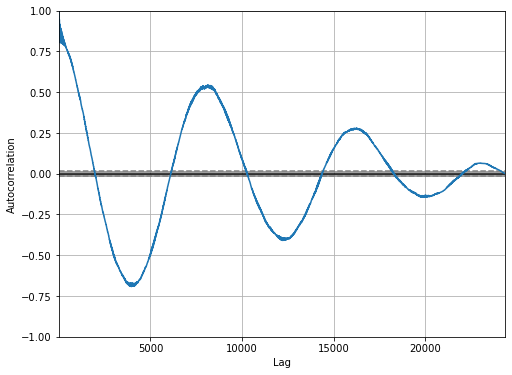

In [16]:
pd.plotting.autocorrelation_plot(aq_df_na['2014':'2016']['TEMP'])

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

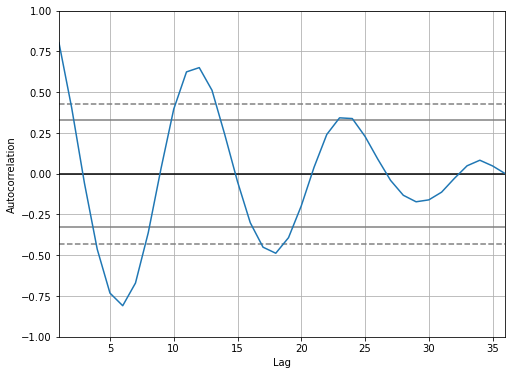

In [17]:
pd.plotting.autocorrelation_plot(aq_df_na['2014':'2016']['TEMP'].resample('1m').mean())

<AxesSubplot:xlabel='y(t)', ylabel='y(t + 1)'>

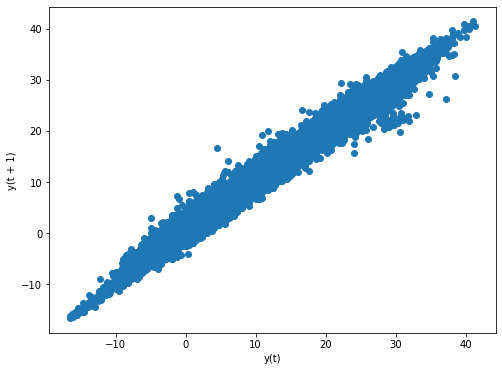

In [18]:
pd.plotting.lag_plot(aq_df['TEMP'], lag=1)

<AxesSubplot:xlabel='y(t)', ylabel='y(t + 3)'>

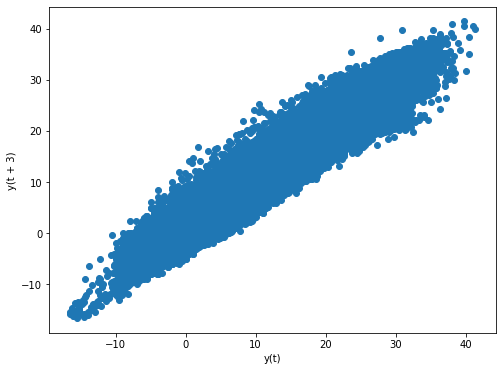

In [19]:
pd.plotting.lag_plot(aq_df['TEMP'], lag=3)

<AxesSubplot:xlabel='y(t)', ylabel='y(t + 24)'>

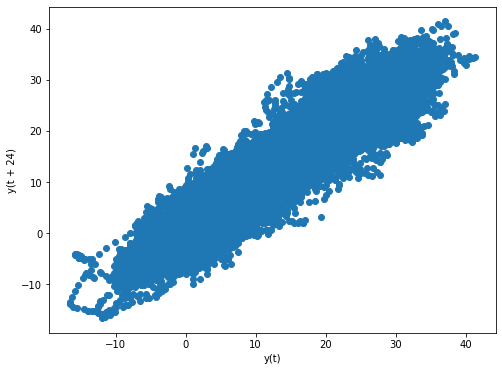

In [20]:
pd.plotting.lag_plot(aq_df['TEMP'], lag=24)

<AxesSubplot:xlabel='y(t)', ylabel='y(t + 8640)'>

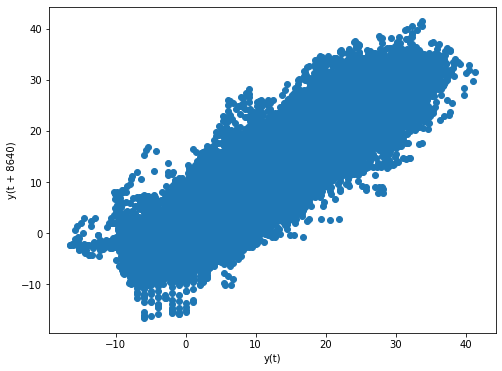

In [21]:
pd.plotting.lag_plot(aq_df['TEMP'], lag=8640)

### taking a particular time interval data and only the TEMP column from that

In [22]:
aq_df_imp = aq_df['2015-02-21 10' : '2015-02-21 23'][['TEMP']]
aq_df_imp

# NOW WE CAN SEE THAT THERE ARE SOME MISSING VALUES AS WELL SO LETS NOW IMPUTE THEM

TEMP
year_month_day_hour      
2015-02-21 10:00:00   1.0
2015-02-21 11:00:00   1.0
2015-02-21 12:00:00   NaN
2015-02-21 13:00:00   2.0
2015-02-21 14:00:00   NaN
2015-02-21 15:00:00   4.0
2015-02-21 16:00:00   4.0
2015-02-21 17:00:00   3.0
2015-02-21 18:00:00   2.0
2015-02-21 19:00:00   1.0
2015-02-21 20:00:00   NaN
2015-02-21 21:00:00  -1.0
2015-02-21 22:00:00  -1.0
2015-02-21 23:00:00  -2.0

### forward fill

In [23]:
aq_df_imp['TEMP_FFILL'] = aq_df_imp['TEMP'].fillna(method='ffill')
aq_df_imp

TEMP  TEMP_FFILL
year_month_day_hour                  
2015-02-21 10:00:00   1.0         1.0
2015-02-21 11:00:00   1.0         1.0
2015-02-21 12:00:00   NaN         1.0
2015-02-21 13:00:00   2.0         2.0
2015-02-21 14:00:00   NaN         2.0
2015-02-21 15:00:00   4.0         4.0
2015-02-21 16:00:00   4.0         4.0
2015-02-21 17:00:00   3.0         3.0
2015-02-21 18:00:00   2.0         2.0
2015-02-21 19:00:00   1.0         1.0
2015-02-21 20:00:00   NaN         1.0
2015-02-21 21:00:00  -1.0        -1.0
2015-02-21 22:00:00  -1.0        -1.0
2015-02-21 23:00:00  -2.0        -2.0

### backward fill

In [24]:
aq_df_imp['TEMP_BFILL'] = aq_df_imp['TEMP'].fillna(method='bfill')
aq_df_imp

TEMP  TEMP_FFILL  TEMP_BFILL
year_month_day_hour                              
2015-02-21 10:00:00   1.0         1.0         1.0
2015-02-21 11:00:00   1.0         1.0         1.0
2015-02-21 12:00:00   NaN         1.0         2.0
2015-02-21 13:00:00   2.0         2.0         2.0
2015-02-21 14:00:00   NaN         2.0         4.0
2015-02-21 15:00:00   4.0         4.0         4.0
2015-02-21 16:00:00   4.0         4.0         4.0
2015-02-21 17:00:00   3.0         3.0         3.0
2015-02-21 18:00:00   2.0         2.0         2.0
2015-02-21 19:00:00   1.0         1.0         1.0
2015-02-21 20:00:00   NaN         1.0        -1.0
2015-02-21 21:00:00  -1.0        -1.0        -1.0
2015-02-21 22:00:00  -1.0        -1.0        -1.0
2015-02-21 23:00:00  -2.0        -2.0        -2.0

### Now taking the average of previous 2 data then imputing the nan values .. if previous 2 data are not present then taking minimum 1 data

### Rolling window fill

In [25]:
aq_df_imp['TEMP'].rolling(window=2, min_periods=1).mean()

year_month_day_hour
2015-02-21 10:00:00    1.0
2015-02-21 11:00:00    1.0
2015-02-21 12:00:00    1.0
2015-02-21 13:00:00    2.0
2015-02-21 14:00:00    2.0
2015-02-21 15:00:00    4.0
2015-02-21 16:00:00    4.0
2015-02-21 17:00:00    3.5
2015-02-21 18:00:00    2.5
2015-02-21 19:00:00    1.5
2015-02-21 20:00:00    1.0
2015-02-21 21:00:00   -1.0
2015-02-21 22:00:00   -1.0
2015-02-21 23:00:00   -1.5
Name: TEMP, dtype: float64

In [26]:
aq_df_imp['TEMP_ROLLING']=aq_df_imp['TEMP'].rolling(window=2, min_periods=1).mean()
aq_df_imp

TEMP  TEMP_FFILL  TEMP_BFILL  TEMP_ROLLING
year_month_day_hour                                            
2015-02-21 10:00:00   1.0         1.0         1.0           1.0
2015-02-21 11:00:00   1.0         1.0         1.0           1.0
2015-02-21 12:00:00   NaN         1.0         2.0           1.0
2015-02-21 13:00:00   2.0         2.0         2.0           2.0
2015-02-21 14:00:00   NaN         2.0         4.0           2.0
2015-02-21 15:00:00   4.0         4.0         4.0           4.0
2015-02-21 16:00:00   4.0         4.0         4.0           4.0
2015-02-21 17:00:00   3.0         3.0         3.0           3.5
2015-02-21 18:00:00   2.0         2.0         2.0           2.5
2015-02-21 19:00:00   1.0         1.0         1.0           1.5
2015-02-21 20:00:00   NaN         1.0        -1.0           1.0
2015-02-21 21:00:00  -1.0        -1.0        -1.0          -1.0
2015-02-21 22:00:00  -1.0        -1.0        -1.0          -1.0
2015-02-21 23:00:00  -2.0        -2.0        -2.0          -1.5

### Date Offset fill

In [27]:
aq_df.loc[aq_df_imp.index + pd.offsets.DateOffset(years=-1)]['TEMP']

year_month_day_hour
2014-02-21 10:00:00    1.4
2014-02-21 11:00:00    2.4
2014-02-21 12:00:00    3.0
2014-02-21 13:00:00    3.8
2014-02-21 14:00:00    3.5
2014-02-21 15:00:00    3.6
2014-02-21 16:00:00    3.3
2014-02-21 17:00:00    2.8
2014-02-21 18:00:00    1.3
2014-02-21 19:00:00    0.7
2014-02-21 20:00:00    1.2
2014-02-21 21:00:00    1.1
2014-02-21 22:00:00    0.7
2014-02-21 23:00:00    0.6
Name: TEMP, dtype: float64

In [28]:
aq_df_imp = aq_df_imp.reset_index()
aq_df_imp

year_month_day_hour  TEMP  TEMP_FFILL  TEMP_BFILL  TEMP_ROLLING
0  2015-02-21 10:00:00   1.0         1.0         1.0           1.0
1  2015-02-21 11:00:00   1.0         1.0         1.0           1.0
2  2015-02-21 12:00:00   NaN         1.0         2.0           1.0
3  2015-02-21 13:00:00   2.0         2.0         2.0           2.0
4  2015-02-21 14:00:00   NaN         2.0         4.0           2.0
5  2015-02-21 15:00:00   4.0         4.0         4.0           4.0
6  2015-02-21 16:00:00   4.0         4.0         4.0           4.0
7  2015-02-21 17:00:00   3.0         3.0         3.0           3.5
8  2015-02-21 18:00:00   2.0         2.0         2.0           2.5
9  2015-02-21 19:00:00   1.0         1.0         1.0           1.5
10 2015-02-21 20:00:00   NaN         1.0        -1.0           1.0
11 2015-02-21 21:00:00  -1.0        -1.0        -1.0          -1.0
12 2015-02-21 22:00:00  -1.0        -1.0        -1.0          -1.0
13 2015-02-21 23:00:00  -2.0        -2.0        -2.0          -1.5

In [30]:
aq_df_imp['TEMP_PREV'] = aq_df_imp.apply(lambda x : aq_df.loc[x['year_month_day_hour'] + pd.offsets.DateOffset(years=-1)]['TEMP'] if pd.isna(x['TEMP']) else x['TEMP'], axis=1)

In [31]:
aq_df_imp

year_month_day_hour  TEMP  TEMP_FFILL  TEMP_BFILL  TEMP_ROLLING  TEMP_PREV
0  2015-02-21 10:00:00   1.0         1.0         1.0           1.0        1.0
1  2015-02-21 11:00:00   1.0         1.0         1.0           1.0        1.0
2  2015-02-21 12:00:00   NaN         1.0         2.0           1.0        3.0
3  2015-02-21 13:00:00   2.0         2.0         2.0           2.0        2.0
4  2015-02-21 14:00:00   NaN         2.0         4.0           2.0        3.5
5  2015-02-21 15:00:00   4.0         4.0         4.0           4.0        4.0
6  2015-02-21 16:00:00   4.0         4.0         4.0           4.0        4.0
7  2015-02-21 17:00:00   3.0         3.0         3.0           3.5        3.0
8  2015-02-21 18:00:00   2.0         2.0         2.0           2.5        2.0
9  2015-02-21 19:00:00   1.0         1.0         1.0           1.5        1.0
10 2015-02-21 20:00:00   NaN         1.0        -1.0           1.0        1.2
11 2015-02-21 21:00:00  -1.0        -1.0        -1.0          -1.0       -1.0
12 2015-02-21 22:00:00  -1.0        -1.0        -1.0          -1.0       -1.0
13 2015-02-21 23:00:00  -2.0        -2.0        -2.0          -1.5       -2.0